# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
#Используется последняя версия 0.9.0 (0.8.0 не получается скачать)
import artm

C:\Users\16735880\bigartm\Python\artm\master_component.py:643: DeprecationWarning: invalid escape sequence \*
  """
C:\Users\16735880\bigartm\Python\artm\master_component.py:753: DeprecationWarning: invalid escape sequence \d
  """
C:\Users\16735880\bigartm\Python\artm\master_component.py:826: DeprecationWarning: 'async' and 'await' will become reserved keywords in Python 3.7
  apply_weight=None, decay_weight=None, async=None):


In [3]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

C:\Anaconda3\lib\site-packages\scipy\_lib\_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
C:\Anaconda3\lib\site-packages\scipy\stats\morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest


In [4]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [5]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [45]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
classes = {}
classes['text'] = 1
classes['author'] = 1
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids=classes)
#строка ниже нужна для версии 0.9.0
model_artm.cache_theta = True

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [46]:
# Ваш код
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [47]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [48]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_1', tau=1e5, dictionary="dictionary", class_ids=["text"], topic_names="bcg"))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [49]:
# Ваш код
#для версии ниже в fit_offline необходимо добавить параметр num_document_passes=1
model_artm.initialize(dictionary="dictionary")
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [50]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_2', tau=-1e5, dictionary="dictionary", class_ids=["text"], topic_names=model_artm.topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [51]:
# Ваш код
#для версии ниже в fit_offline необходимо добавить параметр num_document_passes=1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [313]:
# Ваш код
words = model_artm.score_tracker['top_words_text'].last_tokens
authors = model_artm.score_tracker['top_words_author'].last_tokens
for topic_name in model_artm.topic_names:
    print ('\n' + topic_name + ':\n\n' + ' '.join(words[topic_name]) + '\n\n' + ' '.join(authors[topic_name]))


sbj0:

церковь русь средневековый император святой власть сага князь папа византийский поэзия церковный рим вера король

Александр_Марей Фёдор_Успенский Алексей_Юдин Татьяна_Бобровникова Игорь_Данилевский Елена_Уханова Ольга_Брилева Владимир_Петрухин Елена_Браун Олег_Воскобойников Екатерина_Болтунова Ольга_Тогоева Ольга_Вайнштейн Павел_Уваров Григорий_Бондаренко

sbj1:

планета земля атмосфера вода солнце солнечный белый карлик газ вокруг образовываться поверхность спутник радиус метр

Сергей_Попов Александр_Марков Дмитрий_Вибе Валерий_Сулейманов Дмитрий_Титов Татьяна_Смоктунович Зоригто_Намсараев Владимир_Кузнецов Роман_Рафиков Александр_Слободкин Елизавета_Ривкина Наталья_Новикова Андрей_Глазовский Владимир_Сурдин Сергей_Наугольных

sbj2:

система трудность относительность тест задание преподавание отсчет системный научение компетенция адаптивный обществознание подготовка моделирование спиновый

Елена_Брызгалина Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Эмиль_Ахмедов Мих

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [98]:
sbj_topic_labels = ["церковь", "планета", "система", "наука", "право", "материал", "литература", "смерть", "структура", 
                    "частица", "война", "ребенок", "мозг", "территория", "звезда", "задача", "раса", "философия", "язык", 
                    "революция", "город", "болезнь", "знание", "микроорганизм", "бог", "звук", "страна", "клетка", "температура"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [109]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids=["author"])
theta = model_artm.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

C:\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


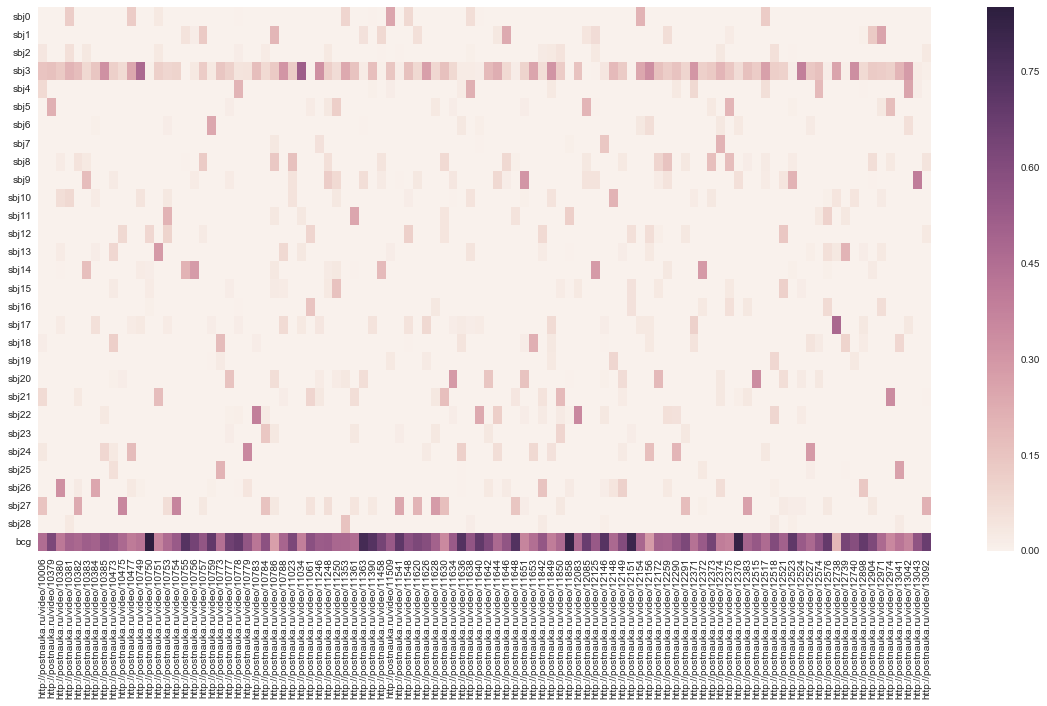

In [84]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(theta.iloc[:,0:100])

In [85]:
theta

,http://postnauka.ru/video/10006,http://postnauka.ru/video/10379,http://postnauka.ru/video/10380,http://postnauka.ru/video/10381,http://postnauka.ru/video/10382,http://postnauka.ru/video/10383,http://postnauka.ru/video/10384,http://postnauka.ru/video/10385,http://postnauka.ru/video/10473,http://postnauka.ru/video/10475,...,http://postnauka.ru/video/19088,http://postnauka.ru/video/19089,http://postnauka.ru/video/19098,http://postnauka.ru/video/19106,http://postnauka.ru/video/19108,http://postnauka.ru/video/19109,http://postnauka.ru/video/1922,http://postnauka.ru/video/1924,http://postnauka.ru/video/19251,http://postnauka.ru/video/1926
sbj0,0.000000e+00,0.000000,0.000000e+00,0.122393,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.199299e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.337135e-03,1.771364e-02,1.000392e-16,0.000000e+00,0.000000e+00,0.000000e+00
sbj1,0.000000e+00,0.000000,2.259040e-12,0.000000,0.000000e+00,0.000000e+00,1.776100e-11,0.000000e+00,0.000000e+00,0.000000e+00,...,1.054623e-12,0.000000e+00,4.962942e-03,0.000000e+00,0.000000e+00,0.000000e+00,9.828001e-06,6.963463e-02,1.212816e-09,0.000000e+00
sbj2,3.687821e-02,0.000000,0.000000e+00,0.058928,0.000000e+00,3.082945e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.129352e-15,9.262865e-03,0.000000e+00,9.810423e-03,0.000000e+00,0.000000e+00,2.401151e-14,3.353816e-03,1.611593e-02
sbj3,1.470150e-01,0.162600,1.320817e-01,0.203632,1.758797e-01,8.462496e-02,1.439841e-01,3.171328e-01,1.110387e-01,7.637050e-02,...,4.651010e-03,8.870215e-03,1.255392e-02,1.444267e-02,3.022927e-02,1.230056e-01,1.225003e-02,1.756156e-03,2.031468e-03,1.296677e-02
sbj4,7.670944e-02,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.594190e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.509478e-16,1.068005e-09
sbj5,0.000000e+00,0.215274,3.113200e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.272685e-02,1.636860e-03,4.403738e-02,4.507020e-02,0.000000e+00,0.000000e+00,3.735504e-03,5.125381e-14,5.431115e-04,2.313606e-02
sbj6,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.911449e-03,0.000000e+00,0.000000e+00,0.000000e+00,...,8.930732e-05,0.000000e+00,0.000000e+00,0.000000e+00,1.303964e-02,2.217010e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sbj7,0.000000e+00,0.000000,2.232753e-09,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.917615e-14,0.000000e+00,0.000000e+00,1.470168e-07,4.385020e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sbj8,0.000000e+00,0.000000,2.209272e-02,0.000000,4.994417e-02,2.867516e-02,0.000000e+00,0.000000e+00,0.000000e+00,2.320540e-07,...,1.802096e-02,5.615357e-05,4.921762e-02,3.288378e-02,0.000000e+00,0.000000e+00,1.265871e-09,2.508987e-03,1.772727e-03,1.576640e-08
sbj9,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.738838e-01,0.000000e+00,0.000000e+00,2.363913e-02,0.000000e+00,...,0.000000e+00,6.671803e-03,1.876419e-01,0.000000e+00,1.368048e-09,5.751749e-14,2.333032e-01,3.905138e-02,1.014718e-02,1.138055e-02


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [287]:
# Ваш код
pt = pd.DataFrame(theta.sum(axis = 1), columns = ["p(t)"])
pt['name'] = topic_labels

In [288]:
print(pt)

              p(t)           name
sbj0     17.879719        церковь
sbj1     18.769295        планета
sbj2     10.201237        система
sbj3     71.317863          наука
sbj4     13.265549          право
sbj5     17.161865       материал
sbj6     12.343420     литература
sbj7      6.642914         смерть
sbj8     18.617874      структура
sbj9     36.205658        частица
sbj10    24.468779          война
sbj11    12.680084        ребенок
sbj12    17.572470           мозг
sbj13    23.705215     территория
sbj14    27.043015         звезда
sbj15    17.786732         задача
sbj16    10.008101           раса
sbj17    23.651505      философия
sbj18    22.864277           язык
sbj19    10.134291      революция
sbj20    15.138359          город
sbj21    16.685764        болезнь
sbj22    16.060551         знание
sbj23    10.220034  микроорганизм
sbj24    14.222286            бог
sbj25     6.882545           звук
sbj26    18.865986         страна
sbj27    38.263702         клетка
sbj28     9.04

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [290]:
print(pt.sort_values(by = "p(t)"))

              p(t)           name
sbj7      6.642914         смерть
sbj25     6.882545           звук
sbj28     9.046089    температура
sbj16    10.008101           раса
sbj19    10.134291      революция
sbj2     10.201237        система
sbj23    10.220034  микроорганизм
sbj6     12.343420     литература
sbj11    12.680084        ребенок
sbj4     13.265549          право
sbj24    14.222286            бог
sbj20    15.138359          город
sbj22    16.060551         знание
sbj21    16.685764        болезнь
sbj5     17.161865       материал
sbj12    17.572470           мозг
sbj15    17.786732         задача
sbj0     17.879719        церковь
sbj8     18.617874      структура
sbj1     18.769295        планета
sbj26    18.865986         страна
sbj18    22.864277           язык
sbj17    23.651505      философия
sbj13    23.705215     территория
sbj10    24.468779          война
sbj14    27.043015         звезда
sbj9     36.205658        частица
sbj27    38.263702         клетка
sbj3     71.31

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

C:\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


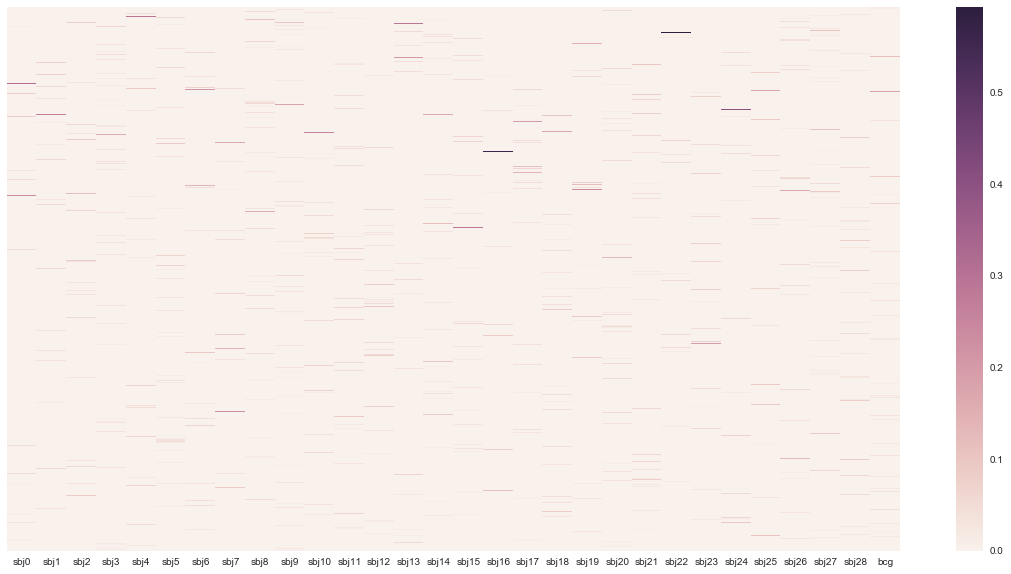

In [111]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [129]:
#наверное естьболее красивый способ это найти, чем указанный ниже
#считаем количество тем, где у автора p(a|t)>0.01
a = {}
for i in range(phi_a.shape[0]):
    a[i] = 0
    for j in phi_a.iloc[i]:
        if (j > 0.01):
            a[i] += 1

In [143]:
#Получаем авторов, где тем >= 3:
for k,v in a.items():
    if (v >= 3):
        print(phi_a.index[k], v)

Алина_Бодрова 3
Илья_Иткин 3
Александр_Воеводский 3
Ольга_Вайнштейн 5
Ольга_Тогоева 3


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [144]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [292]:
pt["p(t)"]

sbj0       17.879719
sbj1       18.769295
sbj2       10.201237
sbj3       71.317863
sbj4       13.265549
sbj5       17.161865
sbj6       12.343420
sbj7        6.642914
sbj8       18.617874
sbj9       36.205658
sbj10      24.468779
sbj11      12.680084
sbj12      17.572470
sbj13      23.705215
sbj14      27.043015
sbj15      17.786732
sbj16      10.008101
sbj17      23.651505
sbj18      22.864277
sbj19      10.134291
sbj20      15.138359
sbj21      16.685764
sbj22      16.060551
sbj23      10.220034
sbj24      14.222286
sbj25       6.882545
sbj26      18.865986
sbj27      38.263702
sbj28       9.046089
bcg      1170.294922
Name: p(t), dtype: float32

In [294]:
# расчет p(a), p(t|a)
pa = np.matmul(phi_a, pt["p(t)"])
pta = np.ndarray((phi_a.shape[1], phi_a.shape[0]))
for i in range(pta.shape[0]):
    for j in range(pta.shape[1]):
        pta[i][j] = phi_a.iloc[j, i] * pt.iloc[i, 0] / pa[j]

In [297]:
# Запуск модели
mds = MDS(n_components=2)
dist_a = pairwise_distances(phi_a, metric='cosine')
#если передавать просто phi_a, то вываливается ошибка "Array must be symmetric", нашел решение на просторах интернета
dist_a_trans = mds.fit_transform(np.array(pta.T, dtype="float64"))

Визуализируйте найденные двумерные представления с помощью функции scatter. 

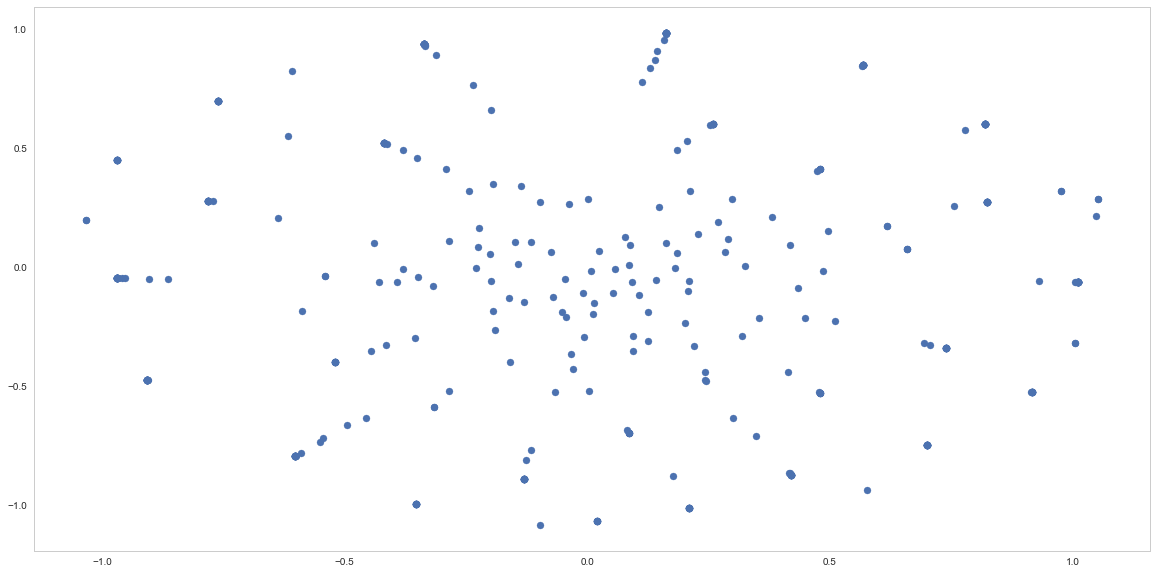

In [298]:
# Постоение графика
plt.figure(figsize=(20,10))
plt.scatter(x=dist_a_trans.T[0], y=dist_a_trans.T[1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [301]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

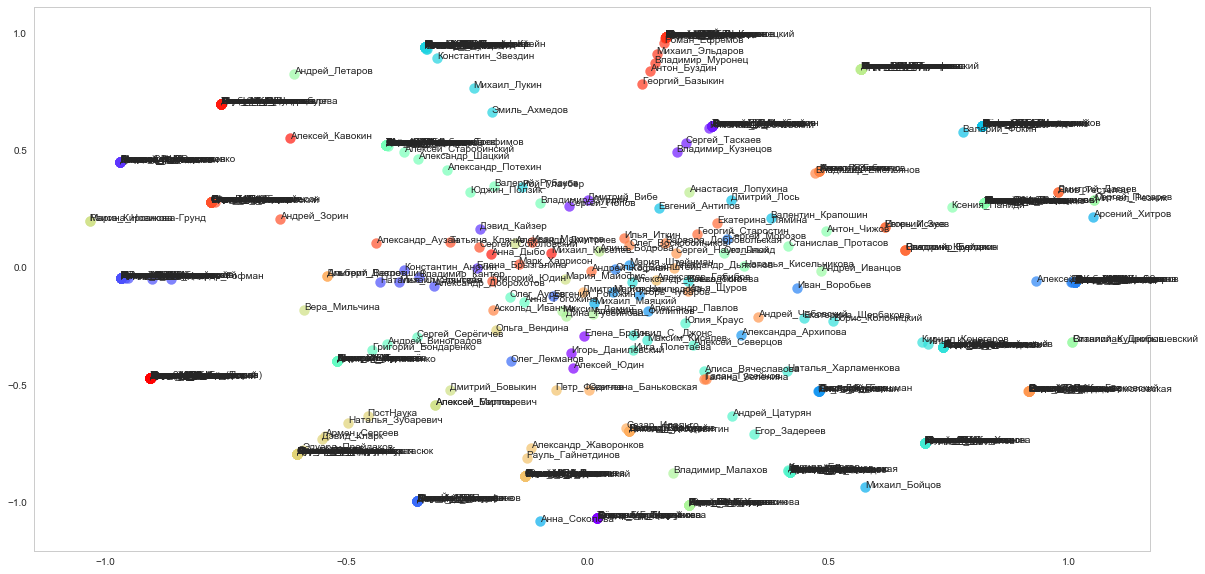

In [304]:
max_prob_topics = np.argmax(pta.T, axis=1)
author_names = phi_a.index.tolist()
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(author_names)):
    plt.annotate(author_names[i], xy=dist_a_trans[i])
    plt.scatter(dist_a_trans[i, 0], dist_a_trans[i, 1],
                c=colors[max_prob_topics[i]], alpha=0.7, s=100)
plt.savefig('authors.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [305]:
# Ваш код
pdt = theta / np.sum(theta)
doc_indexes = (-np.array(pdt)).argsort(axis=1)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [228]:
print ("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [308]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [314]:
# Ваш код
doc_links = pdt.columns.tolist()
for i, t_name in enumerate(model_artm.topic_names[:-1]):
    display(HTML(u"<h1>{}</h1>".format(topic_labels[i])))
    display(HTML(u'<b>Ключевые слова: </b>' + ' '.join(words[t_name])))
    doc_list = ''
    for i in doc_indexes[i][:10]:
        doc_list = doc_list + '<li><a href="' + doc_links[i] + '">' + doc_links[i] + '</a></li>'        
    display(HTML('<ul>' + doc_list + '</ul>'))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 